In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import difflib

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# B2 Principles - Zero shot & one shot - relevant dataframe

## Notebook to evaluate GPT-annotate results - HLS speeches for relevance

Codebooks:
- B2.0: zero shot
- B2.1: one shot
No evaluation of context
-
Test for 5 different seeds [3644,3441, 280, 5991, 7917]
> Refer to these as S1-5

Batch of 20 sentences
1 Iteration.

Main outcomes: T0 - I1
FINGERPRINT USED: fp_43dfabdef1


In [2]:
# Basic stats of train dataset:
HLS_train = pd.read_csv('data/string/HLS_train_string.csv')

In [18]:
HLS_train['PRINCIPLE'].value_counts()

not evaluated                  992
prioritarian                    66
utilitarian                     59
egalitarian                     52
general normative statement     34
sufficientarian                  8
libertarian                      1
Name: PRINCIPLE, dtype: int64

# 1. Results B2.0

In [4]:
#B1.0
path_B2 = 'STRING_RESULT/B2.0/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B2}/all_iterations_string_T0_7917.csv')

seeds_B1 = {
    "S1": [S1],
    "S2": [S2],
    "S3": [S3],
    "S4": [S4],
    "S5": [S5]
}

### 2. Evaluate missed batches

In [5]:
# Evaluate missed batches
B2_missed = pd.read_csv('STRING_RESULT/B2.0/T0_missed_batches.csv')
B2_missed

,Unnamed: 0,Missed batch
0,0,3441 - I1 - B8
1,1,280 - I1 - B1
2,2,280 - I1 - B11


A lot more complete results - fingerprint more steady.

The fact that batches are missed must be taken into account when evaluating accuracy and performance.

> let op: laatste batch heeft minder zinnen

## 2. Evaluate metrics
Evaluation is performed with SKLEARN - presenting 5 classification reports

Column PRINCIPLE_x is the ground truth label - PRINCIPLE_y is the predicted label

Save as dataframes - if neccessary

In [8]:
print(classification_report(S1['PRINCIPLE_x'],S1['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.75      0.65      0.69        51
general normative statement       0.52      0.33      0.41        33
                libertarian       0.00      0.00      0.00         1
               prioritarian       0.79      0.79      0.79        66
            sufficientarian       0.40      0.50      0.44         8
                utilitarian       0.61      0.78      0.68        59

                   accuracy                           0.67       218
                  macro avg       0.51      0.51      0.50       218
               weighted avg       0.67      0.67      0.66       218



In [13]:
print(classification_report(S2['PRINCIPLE_x'],S2['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.70      0.63      0.67        49
general normative statement       0.57      0.41      0.48        29
                libertarian       0.00      0.00      0.00         1
               prioritarian       0.77      0.76      0.77        58
            sufficientarian       0.36      0.50      0.42         8
                utilitarian       0.65      0.77      0.71        53

                   accuracy                           0.67       198
                  macro avg       0.51      0.51      0.51       198
               weighted avg       0.67      0.67      0.67       198



In [15]:
print(classification_report(S3['PRINCIPLE_x'],S3['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.74      0.64      0.69        45
general normative statement       0.44      0.30      0.36        27
                libertarian       0.00      0.00      0.00         1
               prioritarian       0.82      0.74      0.78        54
            sufficientarian       0.44      0.67      0.53         6
                utilitarian       0.61      0.83      0.70        47

                   accuracy                           0.67       180
                  macro avg       0.51      0.53      0.51       180
               weighted avg       0.67      0.67      0.66       180



In [16]:
print(classification_report(S4['PRINCIPLE_x'],S4['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.76      0.63      0.69        51
general normative statement       0.48      0.45      0.47        33
                libertarian       0.00      0.00      0.00         1
               prioritarian       0.78      0.76      0.77        66
            sufficientarian       0.40      0.50      0.44         8
                utilitarian       0.64      0.76      0.70        59

                   accuracy                           0.67       218
                  macro avg       0.51      0.52      0.51       218
               weighted avg       0.68      0.67      0.67       218



In [17]:
print(classification_report(S5['PRINCIPLE_x'],S5['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.73      0.65      0.69        51
general normative statement       0.50      0.30      0.38        33
                libertarian       0.00      0.00      0.00         1
               prioritarian       0.78      0.76      0.77        66
            sufficientarian       0.40      0.50      0.44         8
                utilitarian       0.59      0.78      0.67        59

                   accuracy                           0.66       218
                  macro avg       0.50      0.50      0.49       218
               weighted avg       0.66      0.66      0.65       218



Metrics over 5 seeds are very similar.
Macro avg: average of all classes (aka labels)
Weighted avg: weighted average, taking class balances into account.

In [23]:
S1['PRINCIPLE_y'].value_counts()

utilitarian                    76
prioritarian                   66
egalitarian                    44
general normative statement    21
sufficientarian                10
libertarian                     1
Name: PRINCIPLE_y, dtype: int64

## 3. Confusion matrix
Evaluate where misclassifications are found - Again for each seed.

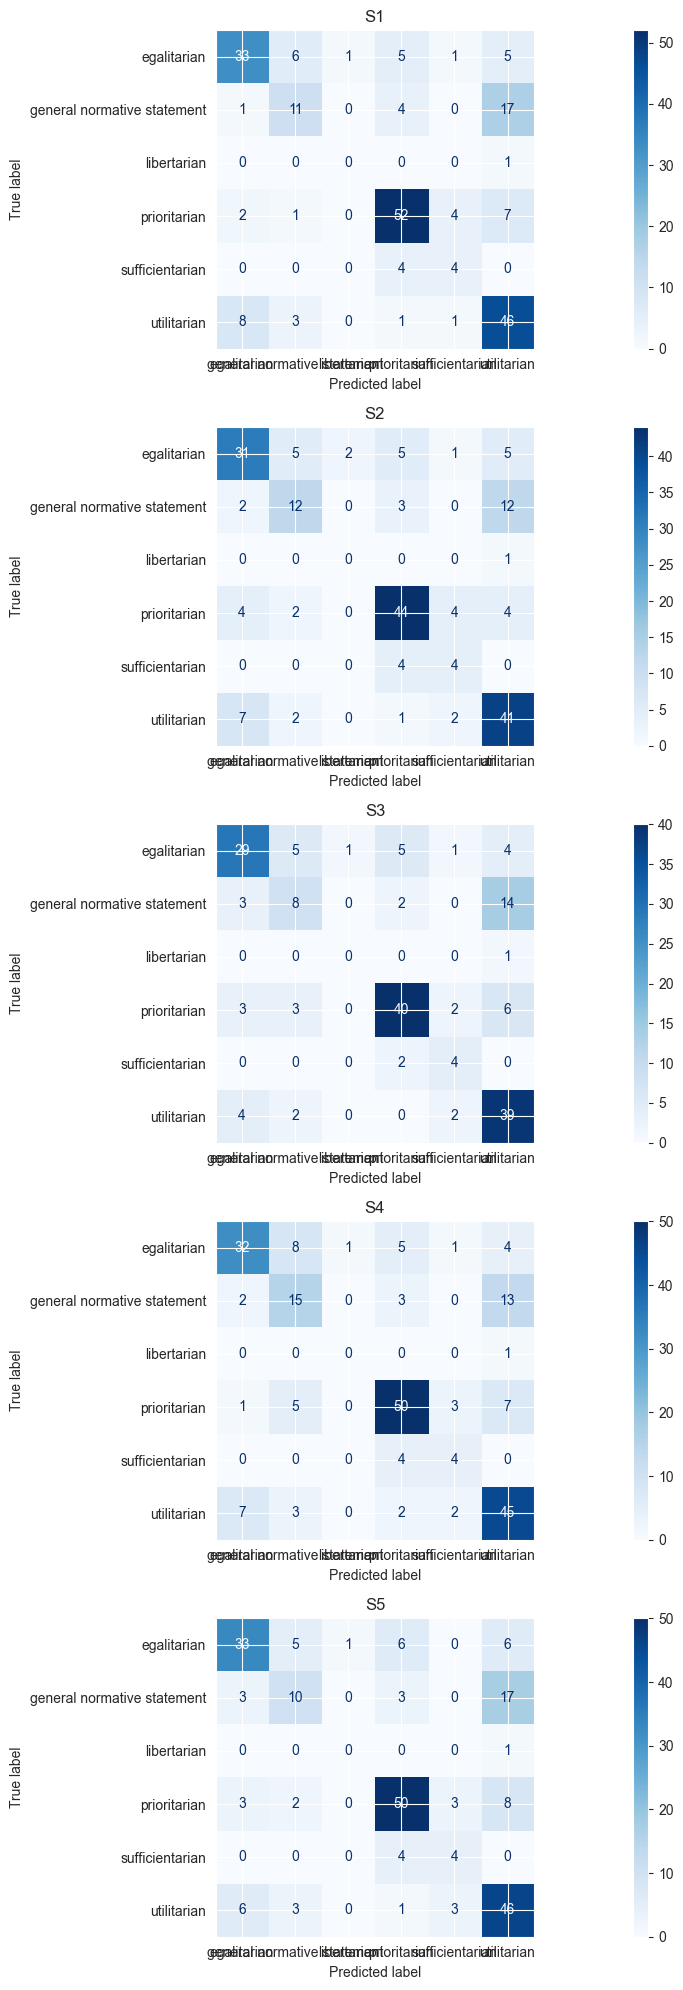

In [25]:
labels = ['egalitarian', 'general normative statement', 'libertarian','prioritarian', 'sufficientarian', 'utilitarian']

# Number of plots
num_plots = len(seeds_B1)
# Create plot names
plot_names = list(seeds_B1.keys())

# Create subplots
fig, axes = plt.subplots(num_plots, 1, figsize=(20, 20))

# Visualize the confusion matrix
for i, name in enumerate(plot_names):
    df = seeds_B1[name][0]  # Access the dataframe
    cm = confusion_matrix(df['PRINCIPLE_x'], df['PRINCIPLE_y'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=axes[i])
    axes[i].set_title(name)

# Adjust layout
plt.tight_layout()
plt.show()

## 4. Evaluate misclassifications of sentences
Special interest in relevant sentences that are incorrectly classified. Evaluate if the same sentences are misclassified in each seed

# 2. Results B2.1 - one shot principles

In [26]:
#B2.1
path_B21 = 'STRING_RESULT/B2.1/all_iterations'

# Open all dataframes
S1_21 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_3644.csv')
S2_21 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_3441.csv')
S3_21 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_280.csv')
S4_21 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_5991.csv')
S5_21 = pd.read_csv(f'{path_B21}/all_iterations_string_T0_7917.csv')

seeds_B21 = {
    "S1": [S1_21],
    "S2": [S2_21],
    "S3": [S3_21],
    "S4": [S4_21],
    "S5": [S5_21]
}

### 2. Evaluate missed batches

In [27]:
# Evaluate missed batches
B21_missed = pd.read_csv('STRING_RESULT/B2.1/T0_missed_batches.csv')
B21_missed

,Unnamed: 0,Missed batch
0,0,3441 - I1 - B8
1,1,280 - I1 - B1
2,2,280 - I1 - B11
3,3,3644 - I1 - B3
4,4,3644 - I1 - B7
5,5,280 - I1 - B9
6,6,5991 - I1 - B5


> note evaluations

## 2. Evaluate metrics
Evaluation is performed with SKLEARN - presenting 5 classification reports

Column RELEVANCE_x is the ground truth label - RELEVANCE_y is the predicted label

Save as dataframes - if neccessary

In [29]:
print(classification_report(S1_21['PRINCIPLE_x'],S1_21['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.59      0.56      0.57        36
general normative statement       0.43      0.40      0.42        25
                libertarian       1.00      1.00      1.00         1
               prioritarian       0.82      0.82      0.82        56
            sufficientarian       0.62      0.71      0.67         7
                utilitarian       0.73      0.77      0.75        53

                   accuracy                           0.69       178
                  macro avg       0.70      0.71      0.70       178
               weighted avg       0.69      0.69      0.69       178



In [30]:
print(classification_report(S2_21['PRINCIPLE_x'],S2_21['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.62      0.55      0.58        51
general normative statement       0.42      0.42      0.42        33
                libertarian       0.50      1.00      0.67         1
               prioritarian       0.82      0.77      0.80        66
            sufficientarian       0.50      0.75      0.60         8
                utilitarian       0.67      0.73      0.70        59

                   accuracy                           0.66       218
                  macro avg       0.59      0.70      0.63       218
               weighted avg       0.66      0.66      0.66       218



In [32]:
print(classification_report(S3_21['PRINCIPLE_x'],S3_21['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.65      0.59      0.62        41
general normative statement       0.48      0.44      0.46        32
                libertarian       0.50      1.00      0.67         1
               prioritarian       0.80      0.81      0.80        63
            sufficientarian       0.56      0.71      0.63         7
                utilitarian       0.70      0.74      0.72        54

                   accuracy                           0.68       198
                  macro avg       0.61      0.71      0.65       198
               weighted avg       0.68      0.68      0.68       198



In [33]:
print(classification_report(S4_21['PRINCIPLE_x'],S4_21['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.70      0.57      0.63        49
general normative statement       0.43      0.47      0.45        32
                libertarian       0.50      1.00      0.67         1
               prioritarian       0.80      0.78      0.79        58
            sufficientarian       0.45      0.71      0.56         7
                utilitarian       0.67      0.71      0.69        51

                   accuracy                           0.66       198
                  macro avg       0.59      0.71      0.63       198
               weighted avg       0.67      0.66      0.66       198



In [35]:
print(classification_report(S5_21['PRINCIPLE_x'],S5_21['PRINCIPLE_y']))

                             precision    recall  f1-score   support

                egalitarian       0.64      0.57      0.60        51
general normative statement       0.45      0.45      0.45        33
                libertarian       0.50      1.00      0.67         1
               prioritarian       0.82      0.77      0.80        66
            sufficientarian       0.55      0.75      0.63         8
                utilitarian       0.68      0.75      0.71        59

                   accuracy                           0.67       218
                  macro avg       0.61      0.72      0.64       218
               weighted avg       0.67      0.67      0.67       218

